In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from transformers import AutoModel, AutoTokenizer
import torch
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import maximum_flow
import networkx as nx
import numpy as np
from tqdm import trange

In [9]:
# load the model
# it would be better to use a task-specifically fine-tuned model

modelname = "princeton-nlp/sup-simcse-roberta-base"
model = AutoModel.from_pretrained(modelname)
tokenizer = AutoTokenizer.from_pretrained(modelname)

In [10]:
# encode a sentence
sent = "This is not a sentence."
encoded_input = tokenizer(sent, padding=True, return_tensors="pt")
with torch.no_grad():
    model_output = model(**encoded_input, output_hidden_states=True, output_attentions=True)

In [11]:
# number of heads
noh = model.config.num_attention_heads

# number of layers
nol = model.config.num_hidden_layers

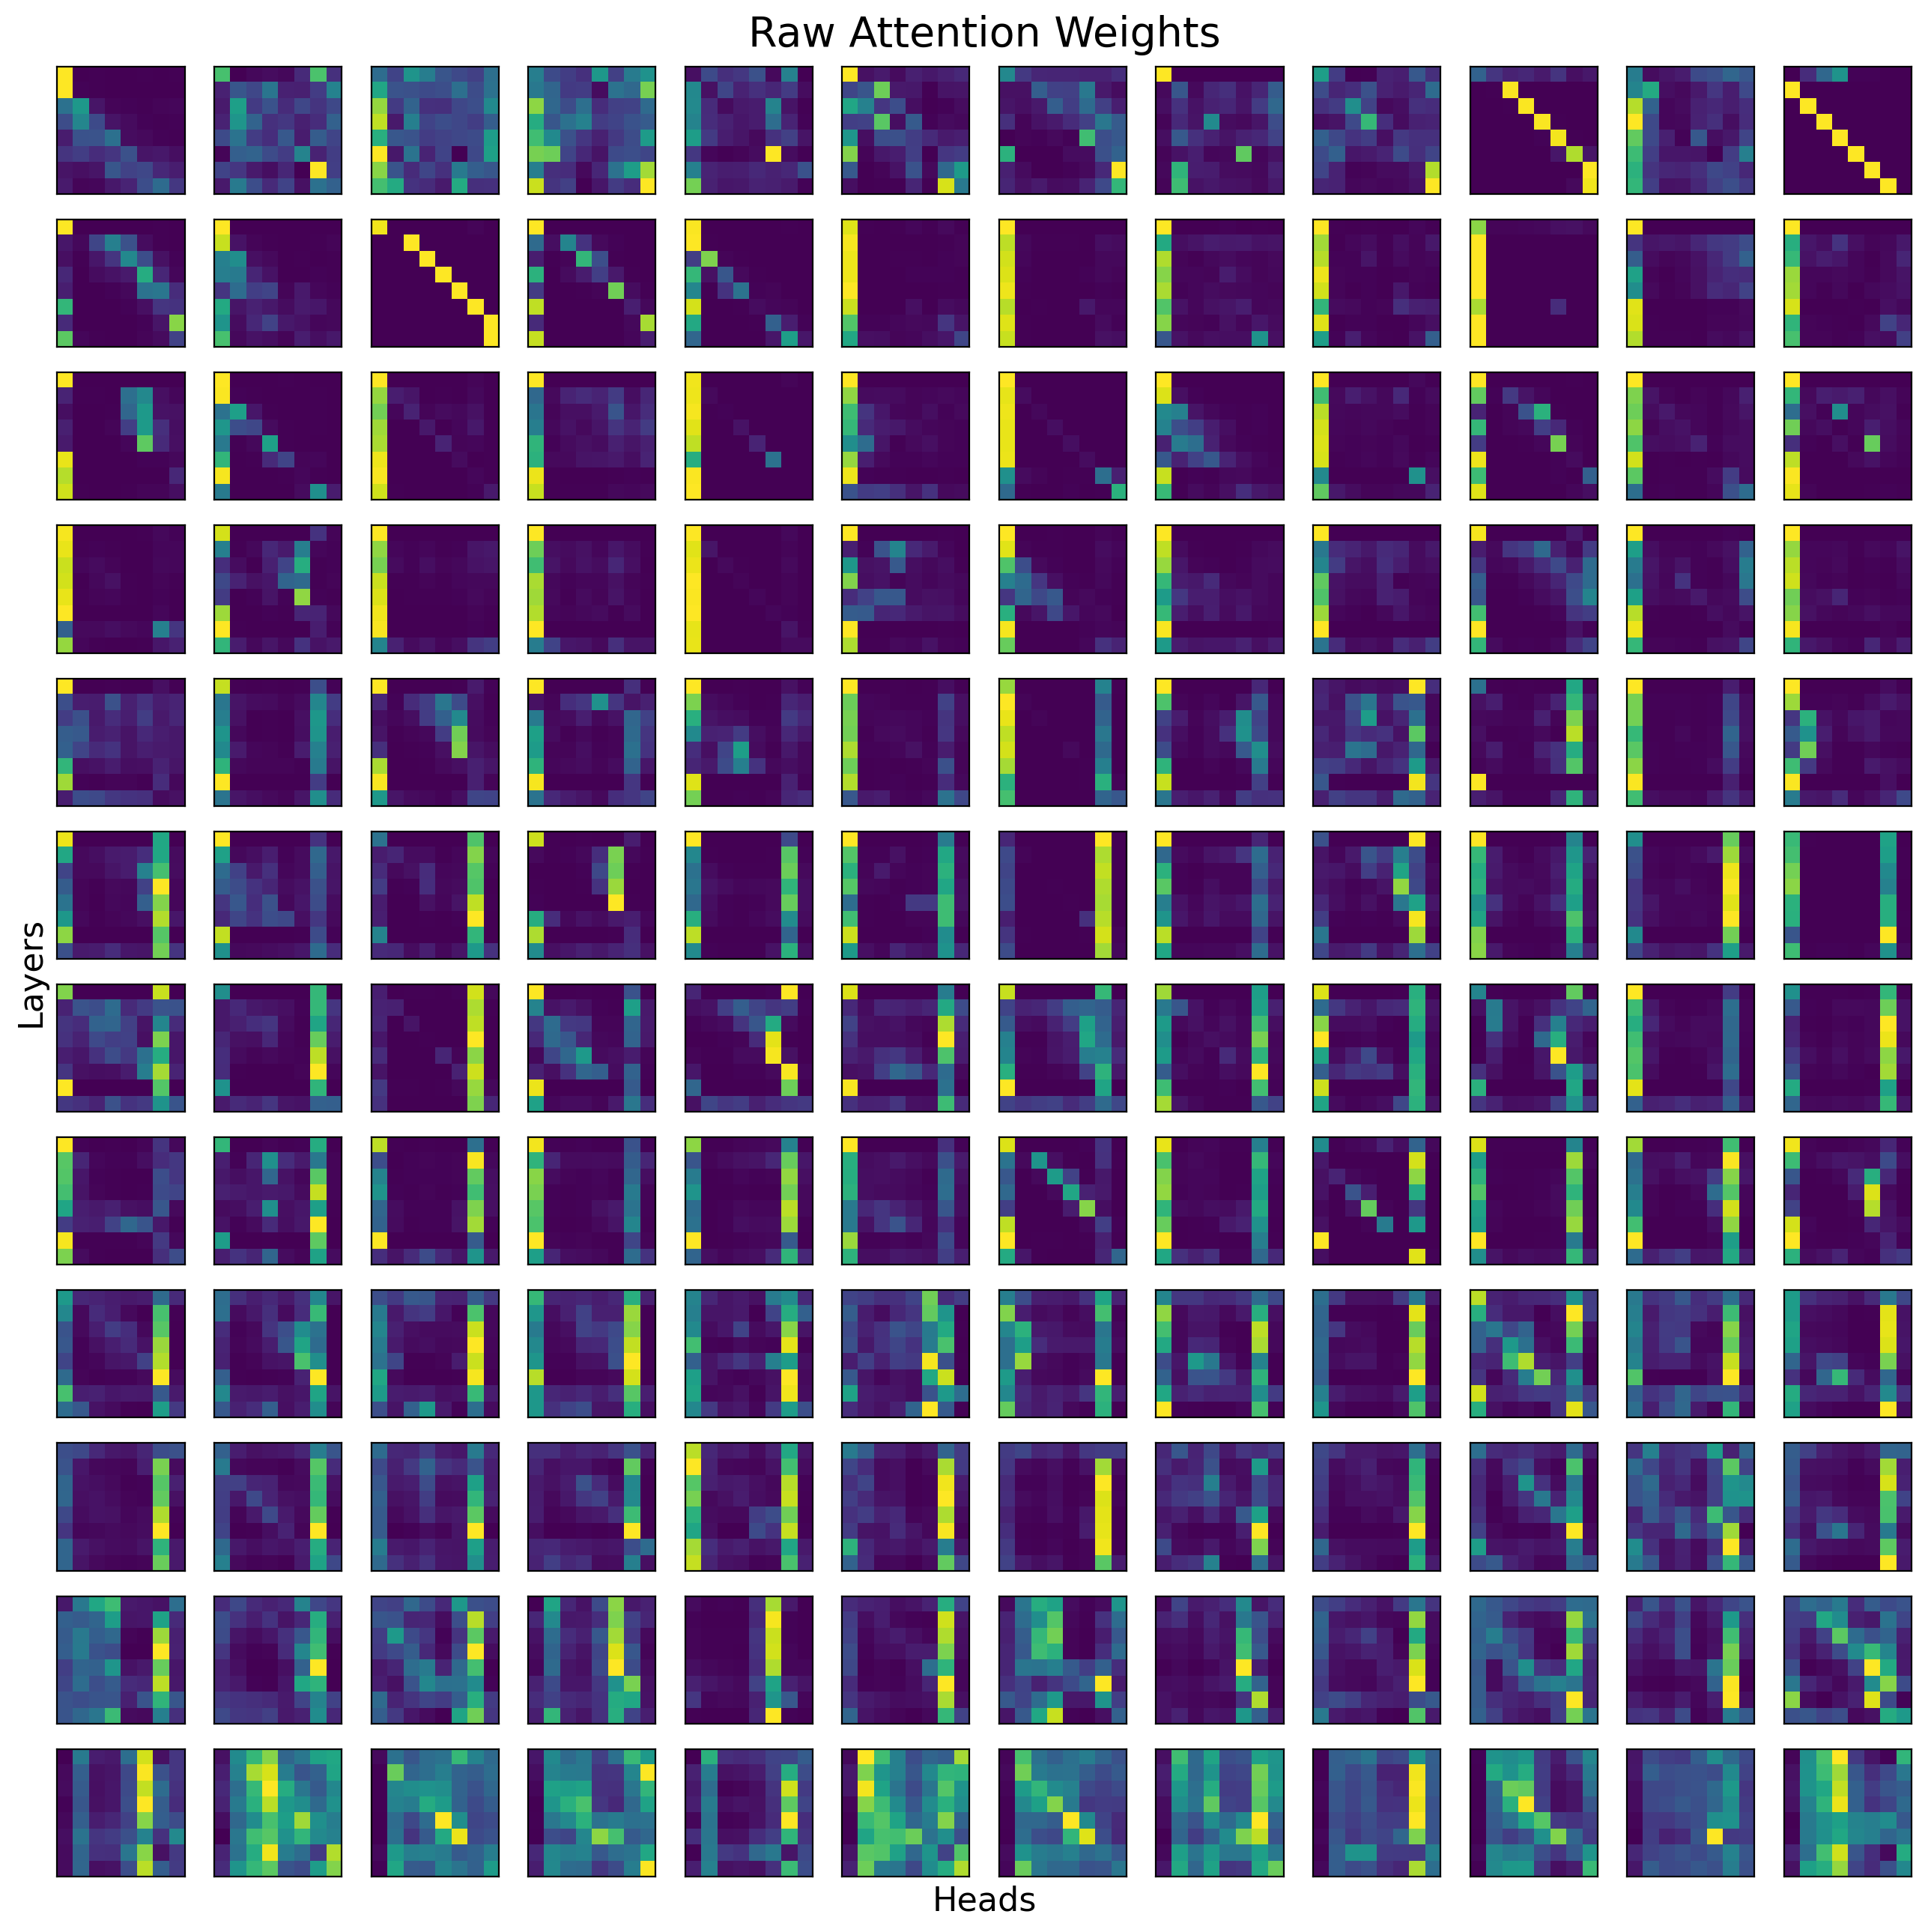

In [12]:
# the raw attention weights

fig, axes = plt.subplots(figsize=(16, 16), dpi=200)
columns = noh
rows = nol

# loop over layers
for i in range(nol):

    # loop over heads
    for j in range(noh):

        # get the attention matrix
        # only 1 sentence, hence the index 0
        W_att = model_output["attentions"][i][0,j]

        ax = fig.add_subplot(rows, columns, i*columns + j + 1)
        ax.imshow(W_att)

        # ticks are not informative
        ax.set_xticks([])
        ax.set_yticks([])

axes.set_title("Raw Attention Weights", fontsize=20, pad=10)
axes.set_xlabel("Heads", fontsize=16)
axes.set_ylabel("Layers", fontsize=16)

# remove the frame but keep the axis labels
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.spines["left"].set_visible(False)
axes.spines["bottom"].set_visible(False)
axes.set_xticks([])
axes.set_yticks([])

plt.show()

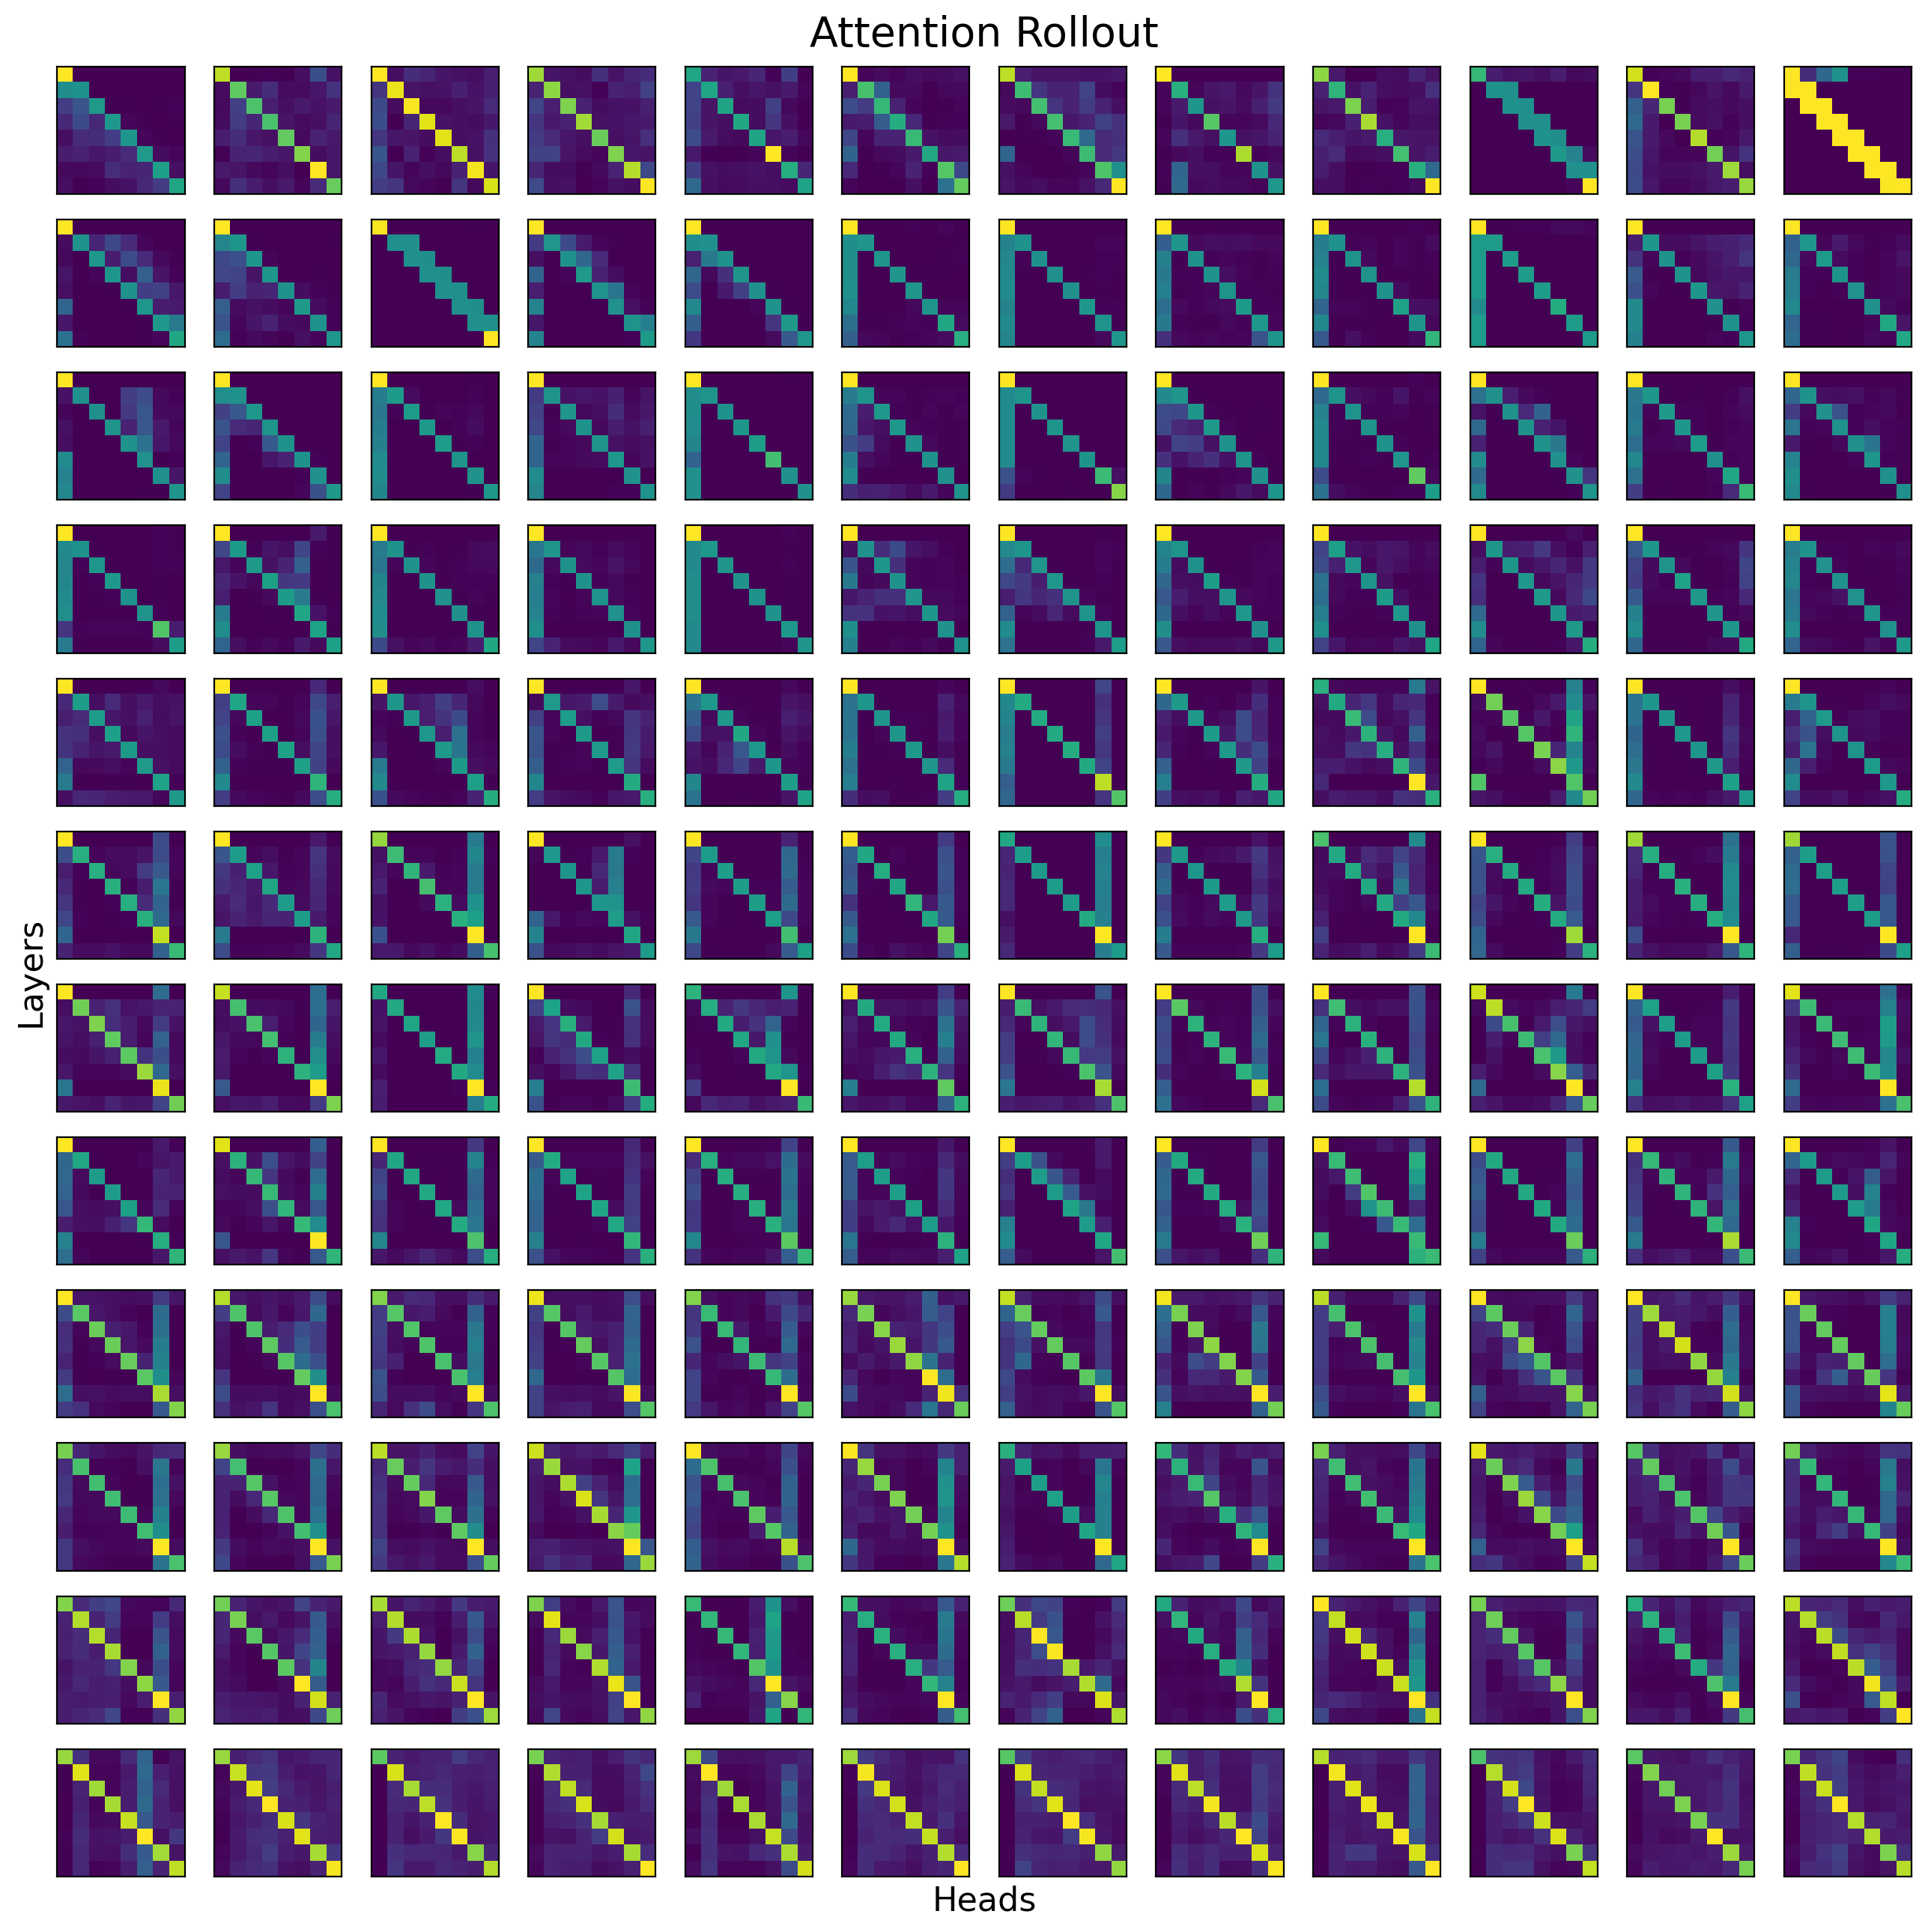

In [13]:
# attention rollout

fig, axes = plt.subplots(figsize=(16, 16), dpi=200)
columns = noh
rows = nol

# save the iterative results
As = []

# layer
for i in range(nol):

    # head
    for j in range(noh):

        # consider residual connection
        W_att = model_output["attentions"][i][0,j]
        A = 0.5 * W_att + 0.5 * torch.eye(W_att.shape[0])

        if not i:
            As.append(A)
        else:
            As[j] = A @ As[j]

        ax = fig.add_subplot(rows, columns, i*columns + j + 1)

        ax.imshow(A)

        # ticks are not informative
        ax.set_xticks([])
        ax.set_yticks([])

axes.set_title("Attention Rollout", fontsize=20, pad=10)
axes.set_xlabel("Heads", fontsize=16)
axes.set_ylabel("Layers", fontsize=16)

# remove the frame but keep the axis labels
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.spines["left"].set_visible(False)
axes.spines["bottom"].set_visible(False)
axes.set_xticks([])
axes.set_yticks([])

plt.show()

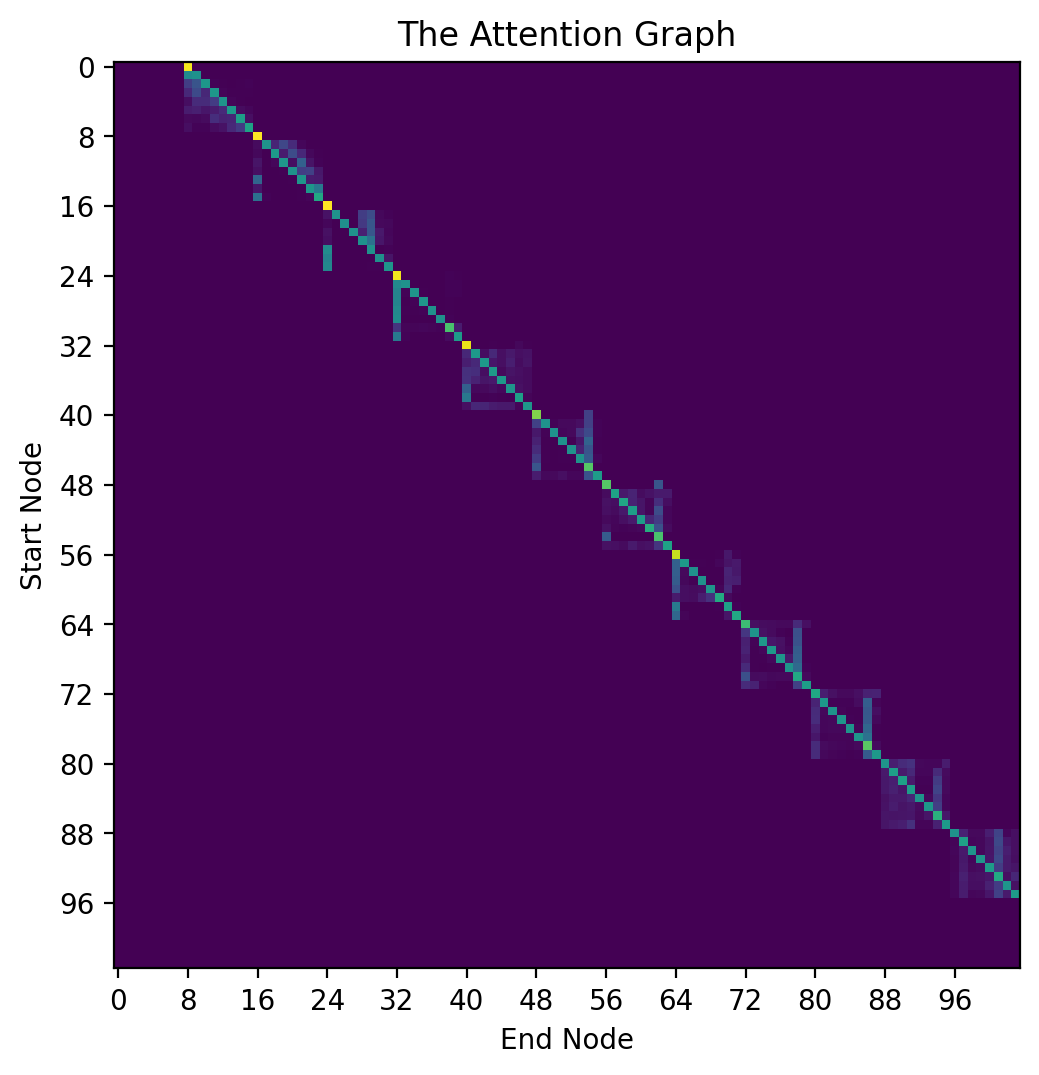

In [14]:
# attention flow

sent_len = model_output["attentions"][0].shape[-1]

# number of nodes
non = (nol + 1) * sent_len

# construct the graph
x = np.zeros((non, non))

# consider a single head
# the original paper averages over all heads
for i in range(nol):
    for j in range(1):
        W_att = model_output["attentions"][i][0,j]
        A = 0.5 * W_att + 0.5 * torch.eye(W_att.shape[0])

        # copy the edge weights
        x[i*sent_len:(i+1)*sent_len, (i+1)*sent_len:(i+2)*sent_len] = A

fig, ax = plt.subplots(figsize=(6,6), dpi=200)
ax.imshow(x)
ax.set_title("The Attention Graph")
ax.set_xlabel("End Node")
ax.set_ylabel("Start Node")
ax.set_xticks(range(0, non, sent_len))
ax.set_yticks(range(0, non, sent_len))
plt.show()

100%|██████████| 12/12 [01:03<00:00,  5.26s/it]


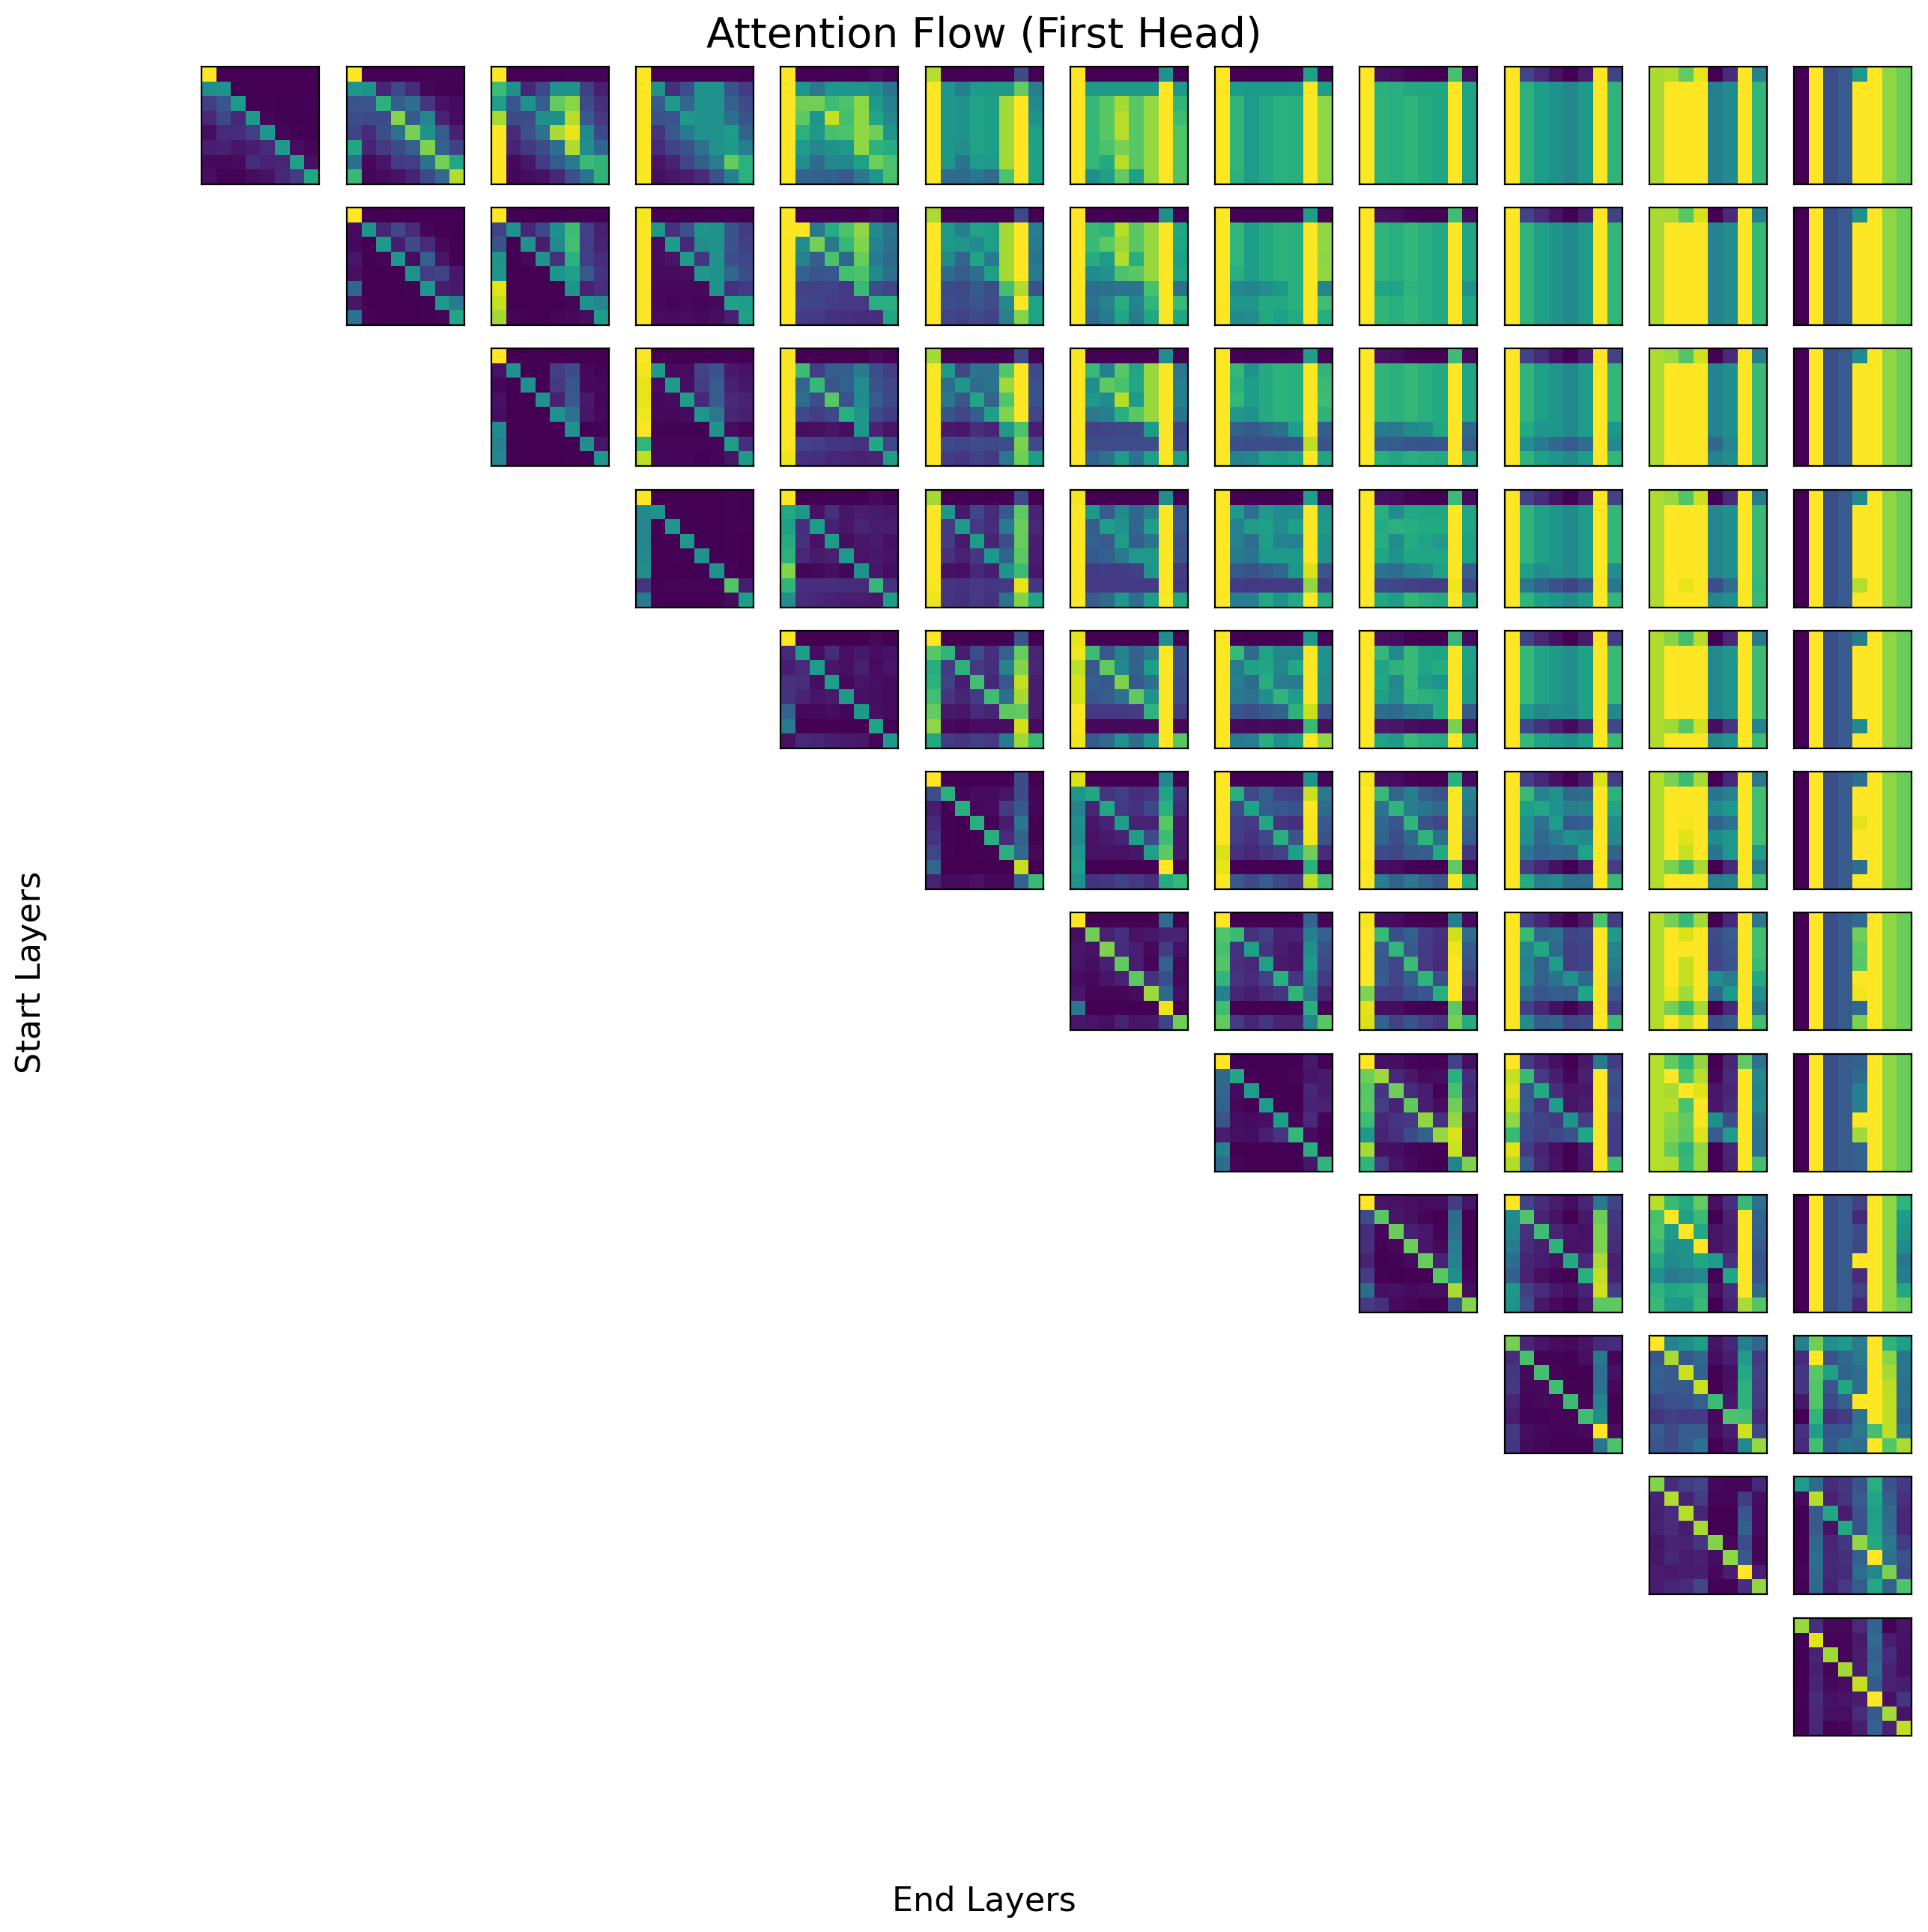

In [15]:
# build the graph, referred to the original paper's code
G = nx.from_numpy_array(x, create_using=nx.DiGraph())
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        nx.set_edge_attributes(G, {(i,j): x[i,j]}, "capacity")

fig, axes = plt.subplots(figsize=(16, 16), dpi=200)
columns = nol+1
rows = nol+1

# the start layer
for i in trange(12):

    # the end layer
    for j in range(i+1, 13):

        # save flow values
        fvs = np.zeros((sent_len, sent_len))

        # get flow for each pair of points
        # the flow originating from CLS in the first layer would be more useful
        for p in range(sent_len):
            for q in range(sent_len):
                flow_value, flow_dict = nx.maximum_flow(G, i*sent_len + p, j*sent_len+q)
                fvs[p,q] = flow_value

        ax = fig.add_subplot(rows, columns, i*columns + j + 1)

        ax.imshow(fvs)

        # ticks are not informative
        ax.set_xticks([])
        ax.set_yticks([])

axes.set_title("Attention Flow (First Head)", fontsize=20, pad=10)
axes.set_xlabel("End Layers", fontsize=16)
axes.set_ylabel("Start Layers", fontsize=16)

# remove the frame but keep the axis labels
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.spines["left"].set_visible(False)
axes.spines["bottom"].set_visible(False)
axes.set_xticks([])
axes.set_yticks([])

plt.show()